<a href="https://colab.research.google.com/github/HarshitCodex/AI_Hackathon_2019/blob/master/Xray_Diseases_Keras_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import torch 
from glob import glob
from torch.utils.data import Dataset
from PIL import Image
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from torchvision import datasets, models, transforms

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [0]:
pwd

'/content'

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/


In [0]:
Config.data_path()

PosixPath('/root/.fastai/data')

In [0]:
path= Config.data_path()/'Xray'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/Xray')

In [0]:
!kaggle datasets download -d nih-chest-xrays/sample

 99% 2.08G/2.10G [00:11<00:00, 174MB/s]
100% 2.10G/2.10G [00:11<00:00, 196MB/s]


In [0]:
!unzip \*.zip

Archive:  sample.zip
  inflating: sample_labels.csv       
replace sample.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample.zip              


In [0]:
!unzip \*.zip

Archive:  sample.zip
  inflating: images/00000013_005.png  
  inflating: images/00000013_026.png  
  inflating: images/00000017_001.png  
  inflating: images/00000030_001.png  
  inflating: images/00000032_001.png  
  inflating: images/00000040_003.png  
  inflating: images/00000042_002.png  
  inflating: images/00000057_001.png  
  inflating: images/00000061_002.png  
  inflating: images/00000061_019.png  
  inflating: images/00000061_025.png  
  inflating: images/00000079_000.png  
  inflating: images/00000080_005.png  
  inflating: images/00000083_000.png  
  inflating: images/00000084_000.png  
  inflating: images/00000096_006.png  
  inflating: images/00000099_003.png  
  inflating: images/00000099_006.png  
  inflating: images/00000103_001.png  
  inflating: images/00000116_013.png  
  inflating: images/00000116_019.png  
  inflating: images/00000116_032.png  
  inflating: images/00000116_040.png  
  inflating: images/00000118_011.png  
  inflating: images/00000121_004.png  
  in

In [0]:
cd '/content/images'

/content/images


In [0]:
!ls

00000013_005.png  00007298_002.png  00013996_005.png  00020671_000.png
00000013_026.png  00007302_000.png  00013999_001.png  00020671_001.png
00000017_001.png  00007304_002.png  00013999_005.png  00020673_041.png
00000030_001.png  00007316_000.png  00014004_001.png  00020673_048.png
00000032_001.png  00007322_012.png  00014004_012.png  00020679_000.png
00000040_003.png  00007322_015.png  00014004_013.png  00020680_000.png
00000042_002.png  00007322_016.png  00014004_045.png  00020680_005.png
00000057_001.png  00007322_019.png  00014006_010.png  00020683_000.png
00000061_002.png  00007322_021.png  00014010_006.png  00020691_000.png
00000061_019.png  00007322_030.png  00014015_001.png  00020703_000.png
00000061_025.png  00007328_012.png  00014018_015.png  00020703_009.png
00000079_000.png  00007330_001.png  00014018_016.png  00020705_000.png
00000080_005.png  00007335_000.png  00014022_070.png  00020725_001.png
00000083_000.png  00007339_003.png  00014022_073.png  00020725_019.png
000000

In [0]:
images=glob(os.path.join("/content/images/","*.png"))
images[0:10]

['/content/images/00018252_000.png',
 '/content/images/00004808_022.png',
 '/content/images/00005177_000.png',
 '/content/images/00004973_001.png',
 '/content/images/00010548_003.png',
 '/content/images/00022947_001.png',
 '/content/images/00008626_029.png',
 '/content/images/00011065_007.png',
 '/content/images/00001160_000.png',
 '/content/images/00003122_015.png']

In [0]:
labels=pd.read_csv('/content/sample_labels.csv')
labels.head(15)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168000,0.168000
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,0.139000
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,0.139000
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143000,0.143000
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,0.139000


In [0]:
data_image_paths={os.path.basename(x): x for x in glob(os.path.join("/content/images/","*.png"))}
print('Scans found:',len(data_image_paths),', Total Headers',labels.shape[0])

labels['path']=labels['Image Index'].map(data_image_paths.get)
labels.head()

Scans found: 5606 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/content/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/content/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/content/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/content/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,/content/images/00000032_001.png


In [0]:
data=labels

In [0]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(20)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4691,00023791_001.png,,1,23791,055Y,M,PA,2992,2991,0.143000,0.143000,/content/images/00023791_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2283,00011695_003.png,,3,11695,051Y,M,AP,2500,2048,0.168000,0.168000,/content/images/00011695_003.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
763,00004006_053.png,Infiltration,53,4006,036Y,F,AP,2500,2048,0.168000,0.168000,/content/images/00004006_053.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4028,00019846_000.png,Infiltration,0,19846,049Y,F,PA,2992,2991,0.143000,0.143000,/content/images/00019846_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
338,00001821_000.png,,0,1821,056Y,M,PA,2512,2568,0.143000,0.143000,/content/images/00001821_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2977,00014675_020.png,,20,14675,067Y,F,AP,2048,2500,0.168000,0.168000,/content/images/00014675_020.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,00000181_017.png,Infiltration,17,181,050Y,F,AP,2500,2048,0.168000,0.168000,/content/images/00000181_017.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
661,00003426_007.png,,7,3426,058Y,M,AP,2500,2048,0.171000,0.171000,/content/images/00003426_007.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3310,00016360_000.png,,0,16360,043Y,M,PA,2968,2882,0.143000,0.143000,/content/images/00016360_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4516,00022540_000.png,,0,22540,053Y,F,PA,2514,2673,0.143000,0.143000,/content/images/00022540_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
n_classes=len(all_labels)
classes=all_labels

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing.image import img_to_array, array_to_img
%matplotlib inline


Using TensorFlow backend.


In [0]:
data.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'path', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')

In [0]:
train_image = []

for i in tqdm(range(data.shape[0])):
  img=image.load_img(data['path'][i],target_size=(400,400,3))
  img=img_to_array(img)
  img=img/255
  train_image.append(img)

X=np.array(train_image)

100%|██████████| 5606/5606 [01:29<00:00, 62.36it/s]


In [0]:
X

array([[[[0.329412, 0.329412, 0.329412],
         [0.333333, 0.333333, 0.333333],
         [0.32549 , 0.32549 , 0.32549 ],
         [0.32549 , 0.32549 , 0.32549 ],
         ...,
         [0.019608, 0.019608, 0.019608],
         [0.019608, 0.019608, 0.019608],
         [0.019608, 0.019608, 0.019608],
         [0.019608, 0.019608, 0.019608]],

        [[0.32549 , 0.32549 , 0.32549 ],
         [0.32549 , 0.32549 , 0.32549 ],
         [0.32549 , 0.32549 , 0.32549 ],
         [0.321569, 0.321569, 0.321569],
         ...,
         [0.019608, 0.019608, 0.019608],
         [0.019608, 0.019608, 0.019608],
         [0.019608, 0.019608, 0.019608],
         [0.019608, 0.019608, 0.019608]],

        [[0.376471, 0.376471, 0.376471],
         [0.376471, 0.376471, 0.376471],
         [0.376471, 0.376471, 0.376471],
         [0.368627, 0.368627, 0.368627],
         ...,
         [0.019608, 0.019608, 0.019608],
         [0.019608, 0.019608, 0.019608],
         [0.019608, 0.019608, 0.019608],
         [0

#IGNORE

In [0]:
#IGNORE THIS PLEASE

image_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8,1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.ColorJitter(contrast=0.4,saturation=0.2),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [0]:
#read images and labels
class Chestray(Dataset):
  def __init__(self,data_dir,image_list_file,transform = None):
    image_names=[]
    labels=[]
    with open(image_list_file,"r") as f:
      for line in f:
        items=line.split()
        image_name=items[0]
        label=items[1:];
        label = [int(i) for i in label]
        image_name = os.path.join(data_dir,image_name)
        image_names.append(image_name)
        labels.append(label)
    
    self.image_names=image_names
    self.labels=labels
    self.transform = transform
    
  def __getitem__(self,index):
    image_name=self.image_names[index]
    image=Image.open(image_name).convert('RGB')
    label=self.labels[index]
    if self.transform is not None:
      image=self.transform(image)
    return image, torch.FloatTensor(label)
  def __len__(self):
    return len(self.image_names)

#CONTINUE

In [0]:
X.shape

(5606, 400, 400, 3)

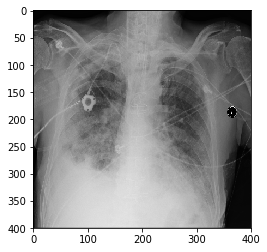

In [0]:
plt.imshow(X[10])

In [0]:
data['Finding Labels'][10]

'Consolidation|Effusion|Infiltration|Nodule'

In [0]:
train=data

In [0]:
y=np.array(train.drop(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'path'],axis=1))

In [0]:
y.shape #cool so now we have only 14 classes that have been one hot encoded into the labels (1/0 for each disease)

(5606, 14)

In [0]:
X_train=X[:4484]

In [0]:
X_train.shape

(4484, 400, 400, 3)

In [0]:
y_train=y[:4484]

In [0]:
y_train.shape

(4484, 14)

In [0]:
X_val=X[4484:5606]
y_val=y[4484:5606]

In [0]:
y_val.shape

(1122, 14)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [0]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(14, activation='sigmoid'))

W0817 07:22:42.367669 140155327858560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 07:22:42.438382 140155327858560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 07:22:42.468439 140155327858560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 07:22:42.502796 140155327858560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0817 07:22:42.509075 140155327858560 deprecation_wrapp

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 396, 396, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 198, 198, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 198, 198, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 194, 194, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 97, 97, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 93, 93, 64)        51264     
__________

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

W0817 07:22:42.972501 140155327858560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0817 07:22:42.992116 140155327858560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0817 07:22:42.996743 140155327858560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=1)